# Supplementary Material

> **"Background-dependent selection of genetic variation in heterogeneous populations"**

> Ignacio Vázquez-García, Francisco Salinas, Jing Li, Andrej Fischer, Benjamin Barré, Johan Hallin, Anders Bergström, Elisa Alonso-Pérez, Jonas Warringer, Ville Mustonen, Gianni Liti

## Figure 1 (+ Supp. Figs.)

This IPython notebook is provided for reproduction of Figure 1 of the paper. It can be viewed by copying its URL to nbviewer and it can be run by opening it in binder.

In [ ]:
# load external dependencies
import matplotlib.pyplot as plt
import matplotlib.lines as lines
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.mlab as mlab
import matplotlib.gridspec as gridspec
import matplotlib.patheffects as PathEffects
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
%matplotlib inline

import glob, os, re
import numpy as np
import pandas as pd # (*) Pandas for data manipulation
import math

import json, matplotlib
s = json.load( open("matplotlibrc.json") )
matplotlib.rcParams.update(s)

%load_ext autoreload
%autoreload 2

# load internal dependencies
import colors,plot,utils,config
from utils import sgd_length
from paths import *

## Data import

In [ ]:
# load data
freq_df = utils.load_data(dir_data+'seq/background/seq_background_freq.pickle')

freq_df.head()

In [ ]:
# load data
seq_qtl_df = utils.load_data(dir_data+'seq/background/seq_background_qtl_llh.pickle')

seq_qtl_df.head()

In [ ]:
# load data
seq_scores_df = utils.load_data(dir_data+'seq/background/seq_background_qtl_scores.pickle')

seq_scores_df.head()

In [ ]:
# load data
seq_mut_df = utils.load_data(dir_data+'seq/de-novo/seq_de_novo_snps_indels.pickle')

seq_mut_df = seq_mut_df.rename(columns={'chrom':'chr_arabic', 'pos':'site'})
seq_mut_df['chr_roman'] = seq_mut_df['chr_arabic'].apply(utils.int_to_roman)
seq_mut_df = utils.chr_to_gw(seq_mut_df)

seq_mut_df = seq_mut_df[seq_mut_df.mutation_type=='driver']

# remap genotypes
seq_mut_df['genotype'] = seq_mut_df['genotype'].map({'0/0': 0, '0/1': 1, '1/0': 1, '1/1': 2})

seq_mut_df['type'] = 'de novo'

seq_mut_df = pd.pivot_table(seq_mut_df, 
                           index=['selection','population','time'], 
                           columns=['chr_arabic','chr_roman','pos','gene'])['frequency']

seq_mut_df.head()

## Figure 1 - Study overview and genome-wide allele frequency changes

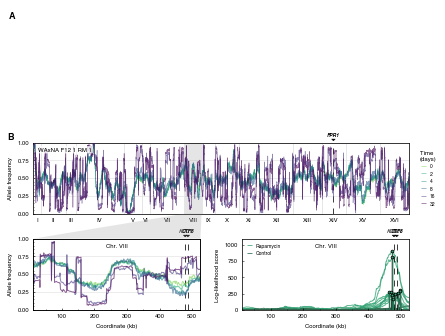

In [55]:
fig = plt.figure(figsize=(6, 5), dpi=300)

grid = gridspec.GridSpec(3, 1, height_ratios=[1.5,1,1], hspace=0.3)

gs = {}
gs['schematic'] = gridspec.GridSpecFromSubplotSpec(1, 3, width_ratios=[1,1,2], subplot_spec=grid[0])
gs['RM'] = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=grid[1])
gs['RM_zoom'] = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=grid[2], wspace=0.25)

### top panel ###
ax0 = plt.subplot(gs['schematic'][0])

ax0.text(-0.225, 1.0,  chr(ord('A')), transform=ax0.transAxes,
         fontsize=9, fontweight='bold', va='top', ha='right')

ax0.axis('off')
ax0.patch.set_visible(False)

### ###
for ii, (env, sample) in enumerate(zip(['RM'],['WAxNA_F12_1_RM_1'])):
    ax1 = plt.subplot(gs[env][0])
    ax1.text(-0.0525, 1.15,  chr(ii+ord('B')), transform=ax1.transAxes,
             fontsize=9, fontweight='bold', va='top', ha='right')


    pdf = freq_df.ix[(env,sample)].T

    colors = [config.dict_time['color'][k] for k in pdf.columns.get_level_values('time')]
    pdf.reset_index().plot(ax=ax1, kind='line',
                           x='pos', y=[0,2,4,8,16,32],
                           color=colors, alpha=0.6, lw=0.5, 
                           legend=False, zorder=3)
    
    ax1.set_xlabel('')
    ax1.set_ylabel('Allele frequency')

    ax1.yaxis.set_major_locator(MaxNLocator(nbins=4))
    ax1.yaxis.set_minor_locator(MaxNLocator(nbins=20))
    ax1.yaxis.set_ticks_position('left')
    
    # grid
    xlabels = sgd_length.chr_start + (sgd_length.chr_end - sgd_length.chr_start)/2.
    xstart = sgd_length.chr_start
    ax1.set_xticks(xlabels)
    ax1.set_xticklabels(sgd_length.chr_arabic.apply(utils.int_to_roman))
    xgrid=[xst+1. for xst in list(set(xstart))]
    [ax1.axvline(g, lw=1, ls="-", color="0.9") for g in xgrid] # vertical lines
    ax1.yaxis.grid(lw=0.75, ls="-", color="0.9") # horizontal lines
    
#     # shades
#     for start, end in zip(sgd_length.chr_start, sgd_length.chr_end):
#         for chrom, g in sgd_length.groupby('chr_arabic'):
#             ax1.axvspan(g.chr_start.squeeze(), g.chr_end.squeeze(),
#                         color=('0.9' if chrom % 2 == 0 else 'w'), lw=0, zorder=0) 
    
    ax1.annotate(sample.replace('_',' '),
                 xy=(0.025, 0.9), xycoords=ax1.transAxes, fontsize=6,
                 color='k', ha='left', va='center',
                 xytext=(-5,0), textcoords='offset points', 
                 bbox=(dict(facecolor='white', edgecolor='none', 
                            alpha=0.75, boxstyle='round,pad=.2')))
    
    ax1.tick_params(axis='x', which='major', size=0, labelsize=6)
    ax1.tick_params(axis='y', which='major', size=2, labelsize=6)
    ax1.tick_params(axis='both', which='minor', size=1, labelsize=4)
    
    # show de novo mutations
    sdn = seq_mut_df.ix[env,sample].dropna(axis=1, how='all')
    
    labels = sdn.columns.get_level_values('gene')
    loc = zip(sdn.columns.get_level_values('pos'), [1.025]*sdn.shape[1])
    
    for gene, (x, y) in zip(labels, loc):
        ax1.axvline(x=x, c='k', ls="--", lw=.75, zorder=2)
        ann = ax1.annotate(gene, xy=(x, y), xycoords=('data', 'axes fraction'), 
                           xytext=(0, 4), textcoords='offset points',
                           arrowprops=dict(arrowstyle='wedge,tail_width=0.7', color='black'),
                           fontsize=5, style='italic', weight='bold',
                           annotation_clip=False, va='bottom', ha='center')
    
    leg1 = ax1.legend(bbox_to_anchor=(1.05, 0.5), ncol=1, 
                      frameon=False, loc='center',
                      borderaxespad=0, handlelength=1, 
                      title='Time \n(days)', prop={'size':5})
    # set the linewidth of each legend object
    for line in leg1.legendHandles:
        line.set_linewidth(.75)
    plt.setp(leg1.get_title(),fontsize=6)
        
### top panel ###
ax2 = plt.subplot(gs['RM_zoom'][0])
ax2_zoom = ax2.twiny()

# draw a bbox of the region of the inset axes in the parent axes and
# connecting lines between the bbox and the inset axes area
xmin = sgd_length[sgd_length.chr_arabic==8].chr_start.squeeze()
xmax = sgd_length[sgd_length.chr_arabic==8].chr_end.squeeze()

ax2_zoom.set_xlim(xmin, xmax)
ax2_zoom.set_xticks([])
ax2_zoom.set_xticklabels([])

plot.zoom_effect(ax1, ax2_zoom, xmin, xmax, edgecolor='none', facecolor='gray')#, edgewidth=5)

freq = freq_df.loc[('RM','WAxNA_F12_1_RM_1'),8].T

colors = [config.dict_time['color'][k] for k in freq.columns.get_level_values('time')]
freq.reset_index().plot(ax=ax2, kind='line',
                        x='site', y=[0,2,4,8,16,32],
                        color=colors, alpha=0.6, lw=1,
                        legend=False)

ax2.set_xlabel('Coordinate (kb)')
ax2.set_ylabel('Allele frequency')

ax2.xaxis.set_major_locator(MaxNLocator(nbins=6))
ax2.xaxis.set_minor_locator(MaxNLocator(nbins=12))
ax2.yaxis.set_major_locator(MaxNLocator(nbins=4))
ax2.yaxis.set_minor_locator(MaxNLocator(nbins=20))
ax2.yaxis.set_ticks_position('left')

ax2.yaxis.grid(lw=0.75, ls="-", color="0.9") # horizontal lines

xticks = ax2.get_xticks()/1E3
ax2.set_xticks(xticks)
ax2.set_xticklabels(xticks.astype(int))

ax2.annotate('Chr. VIII',
             xy=(0.5, 0.9), xycoords=ax2.transAxes, fontsize=6,
             color='k', ha='center', va='center')

### bottom panel ###
ax3 = plt.subplot(gs['RM_zoom'][1], sharex=ax2)

# slice chr. VIII at 30 kb resolution
llh = seq_qtl_df.loc[8,30]
colors = [config.dict_selection['color'][e] for e in llh.columns.get_level_values('selection')]
llh.reset_index().plot(ax=ax3, kind='line',
                       x='site', y=['RM','YPD'],
                       color=colors, alpha=0.75, lw=1,
                       legend=False, zorder=0)

scores = seq_scores_df[30,'RM'].dropna()
markerline, stemlines, baseline = ax3.stem(scores.index.get_level_values('site'), scores.values)
plt.setp(markerline, 'color', config.dict_selection['color']['RM'],
         markersize = 2.75, markeredgewidth=.75, markeredgecolor='k', zorder=3)
plt.setp(stemlines, linewidth=.75, color=config.dict_selection['color']['RM'],
         path_effects=[PathEffects.withStroke(linewidth=1.25, foreground="k")], zorder=2)  
plt.setp(baseline, 'color', 'none', zorder=1)

ax3.set_xlabel('Coordinate (kb)')
ax3.set_ylabel('Log-likelihood score')

# axes limits
ax3.set_ylim(0, 1.1E3)
ax3.xaxis.set_major_locator(MaxNLocator(nbins=6))
ax3.xaxis.set_minor_locator(MaxNLocator(nbins=12))
ax3.xaxis.set_ticks_position('bottom')
ax3.yaxis.set_major_locator(MaxNLocator(nbins=5))
ax3.yaxis.set_ticks_position('left')

# annotation in chromosome coordinates
dict_annotation = {
    'CTF8': {
        'chr': 8,
        'start': 486230,
        'end': 486631
    },
    'KOG1': {
        'chr': 8,
        'start': 475999,
        'end': 480672       
    }
}

RM_artist = lines.Line2D((0,1),(0,0), color=config.dict_selection['color']['RM'], linewidth=.75)
YPD_artist = lines.Line2D((0,1),(0,0), color=config.dict_selection['color']['YPD'], linewidth=.75)

leg3 = ax3.legend([RM_artist,YPD_artist],
                  ['Rapamycin','Control'], ncol=1,
                  frameon=False, loc='upper left',
                  borderaxespad=0.5, handlelength=1, 
                  prop={'size':5})
plt.setp(leg3.get_title(),fontsize=6)

ax3.annotate('Chr. VIII',
             xy=(0.5, 0.9), xycoords=ax3.transAxes, fontsize=6,
             color='k', ha='center', va='center')

for ax in [ax2,ax3]:
    
    ax.tick_params(axis='both', which='major', size=2, labelsize=6)
    ax.tick_params(axis='both', which='minor', size=1, labelsize=4)
    
    for gene in dict_annotation:
        x = dict_annotation[gene]['start'] + (dict_annotation[gene]['end'] - dict_annotation[gene]['start'])/2
        y = 1.025
        ax.axvline(x=x, c='k', ls="--", lw=.75, zorder=1)
        ann = ax.annotate(gene, xy=(x, y), xycoords=('data', 'axes fraction'), 
                          xytext=(0, 4), textcoords='offset points',
                          arrowprops=dict(arrowstyle='wedge,tail_width=0.7', color='black'),
                          fontsize=5, style='italic', weight=('bold' if gene=='CTF8' else 'normal'),
                          annotation_clip=False, va='bottom', ha='center')

# axes limits
for ax in fig.get_axes():

    for sp in ax.spines.values():
        sp.set(color='k', linewidth=0.75, linestyle='-')

    ax.xaxis.label.set_size(6)
    ax.yaxis.label.set_size(6)
    
fig.savefig(dir_paper+'figures/figure1/figure1.png', dpi=300, bbox_inches='tight')
fig.savefig(dir_paper+'figures/figure1/figure1.svg', dpi=300, bbox_inches='tight')
plt.show()

## Figure S3 - Study overview and genome-wide allele frequency changes

YPD WAxNA_F12_1_YPD_1 Int64Index([0, 2, 4, 16, 32], dtype='int64', name=u'time')
YPD WAxNA_F12_1_YPD_2 Int64Index([0, 32], dtype='int64', name=u'time')
YPD

/Users/ivg/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:144: DeprecationWarning: elementwise comparison failed; this will raise the error in the future.
/Users/ivg/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/legend.py:325: UserWarning: Unrecognized location "left". Falling back on "best"; valid locations are
	right
	center left
	upper right
	lower right
	best
	center
	lower left
	center right
	upper left
	upper center
	lower center

  six.iterkeys(self.codes))))


 WAxNA_F12_2_YPD_1 Int64Index([0, 2, 4, 16, 32], dtype='int64', name=u'time')
YPD WAxNA_F12_2_YPD_2 Int64Index([0, 32], dtype='int64', name=u'time')
YPD WAxNA_F2_1_YPD_1 Int64Index([0, 32], dtype='int64', name=u'time')


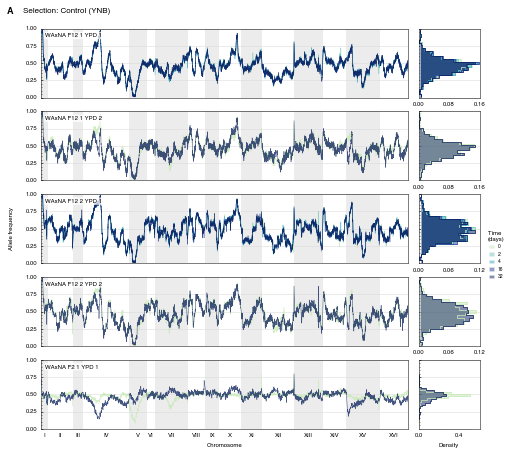

In [8]:
dict_panels = {
    'WAxNA_F2_1_YPD_1':(0,0),
    'WAxNA_F12_1_YPD_1':(1,0), 
    'WAxNA_F12_1_YPD_2':(2,0), 
    'WAxNA_F12_2_YPD_1':(3,0), 
    'WAxNA_F12_2_YPD_2':(4,0),
    'WAxNA_F12_1_HU_1':(5,0), 
    'WAxNA_F12_1_HU_2':(6,0), 
    'WAxNA_F12_1_HU_3':(7,0), 
    'WAxNA_F12_2_HU_1':(8,0), 
    'WAxNA_F12_2_HU_2':(9,0), 
    'WAxNA_F12_2_HU_3':(10,0),
    'WAxNA_F2_1_RM_1':(0,1),
    'WAxNA_F2_2_RM_1':(1,1),
    'WAxNA_F12_1_RM_1':(2,1), 
    'WAxNA_F12_1_RM_2':(3,1), 
    'WAxNA_F12_1_RM_3':(4,1), 
    'WAxNA_F12_1_RM_4':(5,1),
    'WAxNA_F12_2_RM_1':(6,1), 
    'WAxNA_F12_2_RM_2':(7,1), 
    'WAxNA_F12_2_RM_3':(8,1), 
    'WAxNA_F12_2_RM_4':(9,1)
}

# get a figure with a lot of subplots
fig = plt.figure(figsize=(7, 30), dpi=300)

# indexer = [slice(None)]*len(freq_df.index.names)
# indexer[freq_df.index.names.index('sample')] = ['WAxNA_F12_1_YPD_1','WAxNA_F12_1_YPD_2','WAxNA_F12_1_HU_3','WAxNA_F12_1_RM_1']
# gl = freq_df.loc[tuple(indexer),:].dropna(axis=1, how='all')

freq_df = freq_df.ix[['YPD','HU','RM']]

shape = pd.DataFrame({k: 
x.shape for k,x in freq_df.unstack('time').groupby(level=['selection'])
})

ygrid = shape.loc[0,['YPD','HU','RM']].values
grid = gridspec.GridSpec(len(ygrid), 1, height_ratios=ygrid, hspace=0.1)

gs = {}

for ii, (e, sdf) in enumerate(freq_df.ix[['YPD']].groupby(level='selection')):
        
    nrows = len(sdf.index.get_level_values('sample').unique())
    ncols = 2
    gs[e] = gridspec.GridSpecFromSubplotSpec(nrows, ncols,
                                             width_ratios=[6,1],
                                             subplot_spec=grid[ii],
                                             hspace=0.2, wspace=0.05)

    for (jj, (p, pdf)) in enumerate(sdf.groupby(level='sample')):
                
        # retrieve axes
        if jj==0:
            ax1 = plt.subplot(gs[e][jj,0])
            ax2 = plt.subplot(gs[e][jj,1], sharey=ax1)
            # set panel labels
            ax1.text(-0.075, 1.25, chr(ii + ord('A')), transform=ax1.transAxes,
                     fontsize=9, fontweight='bold', va='center', ha='right')
            ax1.text(-0.05, 1.25, 'Selection: %s' % config.dict_selection['long_label'][e], 
                     transform=ax1.transAxes,
                     fontsize=8, va='center', ha='left')
        else:
            ax1 = plt.subplot(gs[e][jj,0], sharex=ax1)
            ax2 = plt.subplot(gs[e][jj,1], sharey=ax1)
        
        pdf = freq_df.ix[(e,p)].T

        colors = [config.dict_time['color'][k] for k in pdf.columns.get_level_values('time')]
#         colors = [plt.cm.viridis_r(x) for x in np.linspace(0, 1, 6)]
        pdf.reset_index().plot(ax=ax1, kind='line',
                               x='pos', y=pdf.columns,
                               color=colors, alpha=0.75, lw=0.5, 
                               legend=False, zorder=3)
    
        ax1.tick_params(axis='x', which='major', size=0, labelsize=6)
        ax1.tick_params(axis='y', which='major', size=2, labelsize=6)
        ax1.tick_params(axis='x', which='minor', size=0, labelsize=4)
        ax1.tick_params(axis='y', which='minor', size=1, labelsize=4)
        
        print e,p,pdf.columns

        for ii,time in enumerate(pdf):    
            x, y = plot.histogram_binned_data(ax2, pdf[time], bins=25)
            ax2.plot(y, x, color=config.dict_time['color'][time], lw=0.75)
            ax2.fill_between(y, 0, x, label=time, alpha=0.5, 
                             facecolor=config.dict_time['color'][time])
            
        ax2.tick_params(axis='both', which='major', size=2, labelsize=6)
        ax2.tick_params(axis='both', which='minor', size=1, labelsize=4)
        
        if (e,p) in [('HU','WAxNA_F12_2_HU_3'),('RM','WAxNA_F2_1_RM_2'),('YPD','WAxNA_F2_1_YPD_1')]:
            ax1.set_xlabel('Chromosome')
            ax2.set_xlabel('Density')
        if (e,p) in [('HU','WAxNA_F12_1_HU_3'),('RM','WAxNA_F12_2_RM_1'),('YPD','WAxNA_F12_2_YPD_1')]:
            xy = {'HU':(-.075, -.15),'RM':(-.075, -.15),'YPD':(-.075, .5)}
            ax1.annotate('Allele frequency', 
                         xy=xy[e], xycoords=ax1.transAxes,
                         color='k', fontsize=6, ha='right', va='center', rotation=90,
                         xytext=(0, 0), textcoords='offset points')
            leg = ax2.legend(bbox_to_anchor=(1.1, .5), ncol=1, 
                             frameon=False, loc='left',
                             borderaxespad=0, handlelength=1, 
                             title='Time \n(days)', prop={'size':5})
            # set the linewidth of each legend object
            for line in leg.legendHandles:
                line.set_linewidth(.75)
            plt.setp(leg.get_title(),fontsize=6)
        
        ax1.set_ylim((0, 1))
        ax1.yaxis.set_major_locator(MaxNLocator(nbins=2))
        ax1.yaxis.set_minor_locator(MaxNLocator(nbins=20))
        ax1.yaxis.set_ticks_position('left')
        
        ax2.set_ylim((0, 1))
        ax2.xaxis.set_major_locator(MaxNLocator(nbins=2))
        ax2.yaxis.set_major_locator(MaxNLocator(nbins=4))
        ax2.yaxis.set_ticks_position('left')
    
        # grid
        xlabels = sgd_length.chr_start + (sgd_length.chr_end - sgd_length.chr_start)/2.
        xstart = sgd_length.chr_start
        ax1.set_xticks(xlabels)
        ax1.set_xticklabels(sgd_length.chr_arabic.apply(utils.int_to_roman))
        xgrid=[xst+1. for xst in list(set(xstart))]
        ax1.yaxis.grid(lw=0.5, ls="-", color="0.85")#, path_effects=[PathEffects.withStroke(linewidth=0.75, foreground="w")]) # horizontal lines
        ax2.yaxis.grid(lw=0.5, ls="-", color="0.85")
        
        # shades
        for start, end in zip(sgd_length.chr_start, sgd_length.chr_end):
            for chrom, g in sgd_length.groupby('chr_arabic'):
                ax1.axvspan(g.chr_start.squeeze(), g.chr_end.squeeze(),
                            color=('0.925' if chrom % 2 == 1 else 'w'), lw=0, zorder=0) 
    
        ax1.annotate(p.replace('_',' '),
                     xy=(0.025, 0.9), xycoords=ax1.transAxes, fontsize=6,
                     color='k', ha='left', va='center',
                     xytext=(-5,0), textcoords='offset points', 
                     bbox=(dict(facecolor='white', edgecolor='none', 
                                alpha=0.75, boxstyle='round,pad=.2')))
        
        # show de novo mutations
        if (e,p) in seq_mut_df.index.values:
            sdn = seq_mut_df.ix[e,p].dropna(axis=1, how='all')
    
            labels = sdn.columns.get_level_values('gene')
            loc = zip(sdn.columns.get_level_values('pos'), [1.01]*sdn.shape[1])
    
            for gene, (x,y) in zip(labels, loc):
                ax1.axvline(x=x, c='k', ls="--", lw=.75, zorder=1)
                ann = ax1.annotate(gene, xy=(x,y), xycoords=('data', 'axes fraction'), 
                                   xytext=(0, 4), textcoords='offset points',
                                   arrowprops=dict(arrowstyle='wedge,tail_width=0.7', color='black'),
                                   fontsize=5, style='italic', weight='bold',
                                   va='bottom', ha='center')

# ax1 = plt.subplot(gs['RM','WAxNA_F12_1_RM_1_T32'][(0,0)])
# ax1.text(-0.05, 3,  chr(ord('B')), transform=ax1.transAxes,
#          fontsize=12, fontweight='bold', va='center', ha='right')
# ax1.text(0, 3,  dict_environment['short_label']['RM'], transform=ax1.transAxes,
#          fontsize=8, va='center', ha='left')
        
# axes limits
for ax in fig.get_axes():
    ax.xaxis.label.set_size(6)
    ax.yaxis.label.set_size(6)
    
    for sp in ax.spines.values():
        sp.set(color='k', linewidth=0.5, linestyle='-')
    
    # turn off the x-axis ticks
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

fig.savefig(dir_supp+'figures/supp_figure_seq_allele_freqs/supp_figure_seq_allele_freqs.png', dpi=300, bbox_inches='tight')
fig.savefig(dir_supp+'figures/supp_figure_seq_allele_freqs/supp_figure_seq_allele_freqs.svg', dpi=300, bbox_inches='tight')
plt.show()